In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)

# **Dataset Daily Min Temp**

In [3]:
dataset = pd.read_csv('/content/drive/My Drive/BCML/datasets/daily-min-temperatures.csv', header=0, parse_dates=[0], index_col=0, squeeze=False, date_parser=parser)
dataset.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


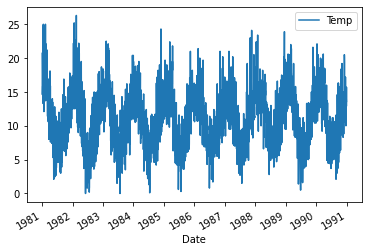

In [4]:
dataset.plot()
plt.show()

## **Penentuan Lag**

In [ ]:
values = dataset.values
size = int(len(values) * 0.75)
train, test = values[0:size], values[size:len(values)]
history = [x for x in train]
predictions = []

In [ ]:
model = AR(train)
model_fit = model.fit()
print('Lag:', model_fit.k_ar)

Lag: 27


In [ ]:
dataset_values = dataset.values

def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.75)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
	print('RMSE = %.2f'%(sqrt(best_score)))

In [ ]:
import warnings

p_values = range(0, 10)
d_values = range(0,1)
q_values = range(0,1)

warnings.filterwarnings("ignore")
evaluate_models(dataset_values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=16.130
ARIMA(1, 0, 0) MSE=6.262
ARIMA(2, 0, 0) MSE=6.216
ARIMA(3, 0, 0) MSE=5.981
ARIMA(4, 0, 0) MSE=5.850
ARIMA(5, 0, 0) MSE=5.706
ARIMA(6, 0, 0) MSE=5.631
ARIMA(7, 0, 0) MSE=5.558
Best ARIMA(7, 0, 0) MSE=5.558
RMSE = 2.36


## **Train Test Split**

In [5]:
lag = 7

raw_values = dataset.values
diff_values = difference(raw_values, 1)

diff_values

0        [-2.8000000000000007]
1         [0.9000000000000021]
2         [-4.200000000000001]
3          [1.200000000000001]
4                        [0.0]
                 ...          
3644     [-0.5999999999999996]
3645    [-0.40000000000000036]
3646    [-0.09999999999999964]
3647      [2.1999999999999993]
3648     [-2.6999999999999993]
Length: 3649, dtype: object

In [6]:
supervised = timeseries_to_supervised(diff_values, lag)
supervised

,0,0,0,0,0,0,0,0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[-2.8000000000000007]
1,[-2.8000000000000007],NaN,NaN,NaN,NaN,NaN,NaN,[0.9000000000000021]
2,[0.9000000000000021],[-2.8000000000000007],NaN,NaN,NaN,NaN,NaN,[-4.200000000000001]
3,[-4.200000000000001],[0.9000000000000021],[-2.8000000000000007],NaN,NaN,NaN,NaN,[1.200000000000001]
4,[1.200000000000001],[-4.200000000000001],[0.9000000000000021],[-2.8000000000000007],NaN,NaN,NaN,[0.0]
...,...,...,...,...,...,...,...,...
3644,[1.6999999999999993],[2.9000000000000004],[-3.9000000000000004],[0.7000000000000011],[0.09999999999999964],[-2.3000000000000007],[0.7000000000000011],[-0.5999999999999996]
3645,[-0.5999999999999996],[1.6999999999999993],[2.9000000000000004],[-3.9000000000000004],[0.7000000000000011],[0.09999999999999964],[-2.3000000000000007],[-0.40000000000000036]
3646,[-0.40000000000000036],[-0.5999999999999996],[1.6999999999999993],[2.9000000000000004],[-3.9000000000000004],[0.7000000000000011],[0.09999999999999964],[-0.09999999999999964]
3647,[-0.09999999999999964],[-0.40000000000000036],[-0.5999999999999996],[1.6999999999999993],[2.9000000000000004],[-3.9000000000000004],[0.7000000000000011],[2.1999999999999993]


In [7]:
supervised_values = supervised.values[lag:,:]
supervised_values

array([[array([1.6]), array([0.]), array([0.]), ..., array([0.9]),
        array([-2.8]), array([4.4])],
       [array([4.4]), array([1.6]), array([0.]), ..., array([-4.2]),
        array([0.9]), array([-1.8])],
       [array([-1.8]), array([4.4]), array([1.6]), ..., array([1.2]),
        array([-4.2]), array([-3.8])],
       ...,
       [array([-0.4]), array([-0.6]), array([1.7]), ..., array([0.7]),
        array([0.1]), array([-0.1])],
       [array([-0.1]), array([-0.4]), array([-0.6]), ..., array([-3.9]),
        array([0.7]), array([2.2])],
       [array([2.2]), array([-0.1]), array([-0.4]), ..., array([2.9]),
        array([-3.9]), array([-2.7])]], dtype=object)

In [8]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1)) # Range hasil scaling menjadi angka diantara -1 hingga 1
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

# Baseline model

In [10]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

model = Sequential()
model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0699 - val_loss: 0.0595
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0563
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0558
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0605 - val_loss: 0.0556
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0603 - val_loss: 0.0555
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.0553
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0551
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0594 - val_loss: 0.0547
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0589 - val_loss: 0.0541
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0580 - val_loss: 0.0531

In [11]:
loss = model.evaluate(feature_test, label_test, verbose=2)

print("Test loss:", loss)

29/29 - 0s - loss: 0.0447
Test loss: 0.044723011553287506


In [12]:
history_dataframe = pd.DataFrame(history.history)
history_dataframe['epoch'] = history.epoch
history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
894,0.049216,0.044650,894
824,0.049219,0.044652,824
460,0.049227,0.044653,460
790,0.049197,0.044655,790
927,0.049203,0.044655,927
...,...,...,...
4,0.060257,0.055464,4
3,0.060457,0.055620,3
2,0.060760,0.055808,2
1,0.062158,0.056301,1


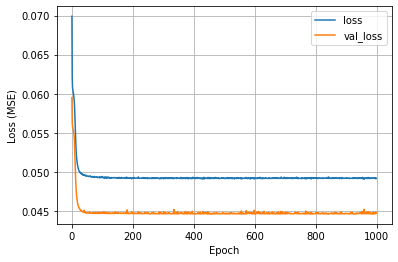

In [13]:
plot_loss(history) # epoch vs loss graph

# Deeper model

In [14]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model = Sequential()
deeper_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model.add(Dense(5, activation='relu'))
deeper_model.add(Dense(1))
deeper_model.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history = deeper_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0673 - val_loss: 0.0580
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0566
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.0561
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0559
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0557
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0556
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0603 - val_loss: 0.0555
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0602 - val_loss: 0.0554
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0552
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0599 - val_loss: 0.0551

In [15]:
deeper_history_dataframe = pd.DataFrame(deeper_model_history.history)
deeper_history_dataframe['epoch'] = deeper_model_history.epoch
deeper_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
925,0.049234,0.044655,925
775,0.049230,0.044657,775
892,0.049206,0.044658,892
658,0.049200,0.044659,658
601,0.049269,0.044659,601
...,...,...,...
4,0.060608,0.055739,4
3,0.060798,0.055915,3
2,0.061106,0.056142,2
1,0.061842,0.056576,1


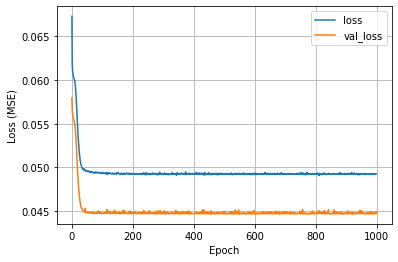

In [16]:
plot_loss(deeper_model_history) # epoch vs loss graph

# Wider model

In [17]:
neurons = 50
epoch = 1000
batch_size = 32

wider_model = Sequential()
wider_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model.add(Dense(1))
wider_model.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history = wider_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0650 - val_loss: 0.0524
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0549 - val_loss: 0.0489
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0520 - val_loss: 0.0473
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0506 - val_loss: 0.0467
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0502 - val_loss: 0.0463
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0493 - val_loss: 0.0460
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0493 - val_loss: 0.0457
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0488 - val_loss: 0.0461
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0485 - val_loss: 0.0459
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0488 - val_loss: 0.0456

In [18]:
wider_history_dataframe = pd.DataFrame(wider_model_history.history)
wider_history_dataframe['epoch'] = wider_model_history.epoch
wider_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
18,0.047608,0.045281,18
34,0.046792,0.045304,34
26,0.047161,0.045342,26
17,0.047812,0.045378,17
37,0.046664,0.045379,37
...,...,...,...
816,0.039996,0.052971,816
905,0.039555,0.052999,905
888,0.039879,0.053298,888
983,0.040155,0.053918,983


# **LSTM**

In [19]:
epoch = 1000
batch_size = 32

# Reshape menjadi (jumlah sample, time steps, jumlah feature)
# Time steps: jumlah lag, gunakan default 1
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1, feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1, feature_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_dim=feature_train.shape[1])) # 50 LSTM Block
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model_history = lstm_model.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 5ms/step - loss: 0.0651 - val_loss: 0.0543
Epoch 2/1000
86/86 [==============================] - 0s 3ms/step - loss: 0.0574 - val_loss: 0.0513
Epoch 3/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0486
Epoch 4/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0468
Epoch 5/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0458
Epoch 6/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0451
Epoch 7/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0448
Epoch 8/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0447
Epoch 9/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0446
Epoch 10/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0448

In [20]:
lstm_history_dataframe = pd.DataFrame(lstm_model_history.history)
lstm_history_dataframe['epoch'] = lstm_model_history.epoch
lstm_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
8,0.048713,0.044639,8
13,0.048187,0.044649,13
12,0.048494,0.044649,12
10,0.048445,0.044667,10
7,0.048817,0.044696,7
...,...,...,...
986,0.035986,0.055095,986
996,0.036000,0.055233,996
784,0.037116,0.055290,784
984,0.035998,0.055940,984


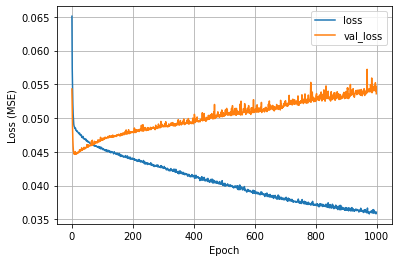

In [21]:
plot_loss(lstm_model_history)

# **Kesimpulan**

Berdasarkan perhitungan diatas dengan lag terbaik yakni 7 (berdasarkan hasil perhitungan ARIMA) didapatkan hasil:

```
Baseline Model: Val_loss 0.044650 Epoch 894
Deeper Model: Val_loss 0.044655 Epoch 925
Wider Model: Val_loss 0.045281 Epoch 18
LSTM: Val_loss 0.044639 Epoch 8
```
melihat dari hasil val_loss yang ada maka dapat di simpulkan **LSTM** mendapatkan hasil yang **terbaik** karena val_loss semakin kecil semakin baik dan juga jika di bandingkan antara lag nya maka lag 7 lebih baik di bandingkan lag 1 ini membuktikan bahwa lag mempengaruhi tingkat akurasi dalam model atau arsitektur TimeSeries.
